# Определение возраста покупателей

**Описание проекта:**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

   - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
   - Контролировать добросовестность кассиров при продаже алкоголя.

Задача: построить модель, которая по фотографии определит приблизительный возраст человека на основании датасета из фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [3]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [4]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В датасете 7591 изображение. В файле labels.csv 2 столбца: с названием соответствующего файла и реальным возрастом человека на фотографии.

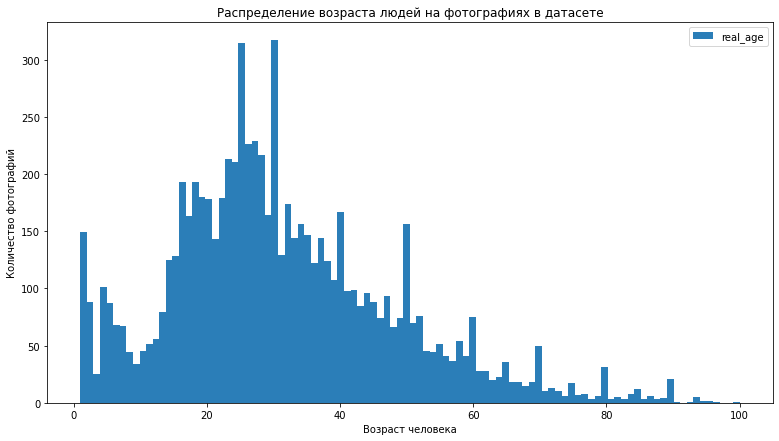

In [30]:
fig, ax = plt.subplots()
ax.set_title('Распределение возраста людей на фотографиях в датасете')
ax.set_xlabel('Возраст человека')
labels.plot(kind='hist', bins=100, figsize=(13,7), ax=ax, alpha=0.95)
ax.set_ylabel('Количество фотографий')
plt.show()

На графике наблюдаем 

In [13]:
print(labels.describe())

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


В выборке представлены фотографии людей возрастом от 1 до 100 лет. На удивление много новорожденных и детей дошкольного возраста. Наблюдаются пики в 30, 35 и 50 лет (и на других "круглых" значениях), но все они не критичны. Возможно, они связаны с тем, что разметка датасета происходила вручную, без документов, и возраст «округлялся» в сомнительных случаях.

Медианное значение составляет 29 лет, среднее - 31,2 года. Людей после 40 лет меньше четверти от датасета (есть перекос в пользу "молодых").


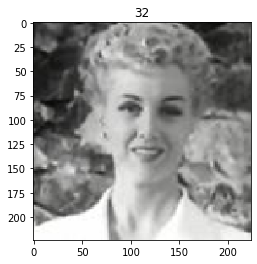

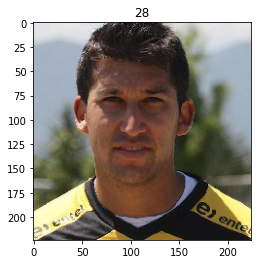

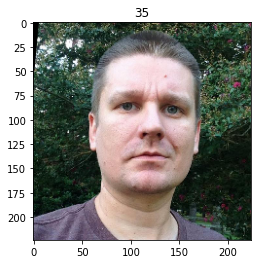

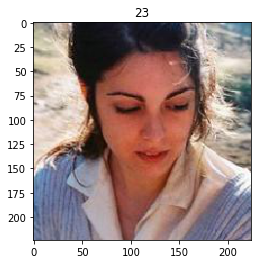

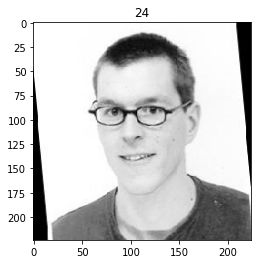

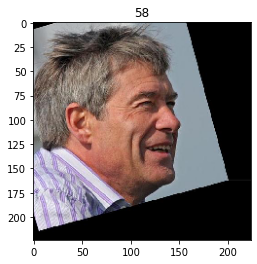

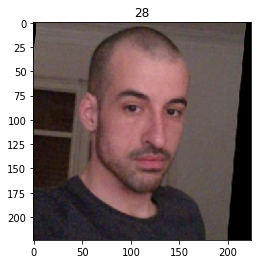

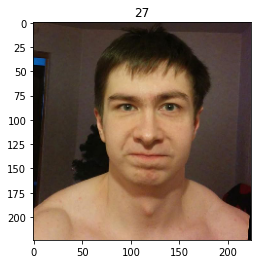

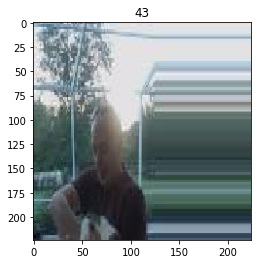

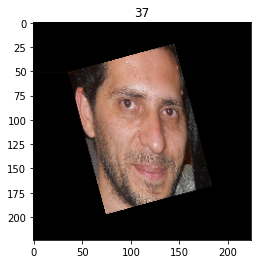

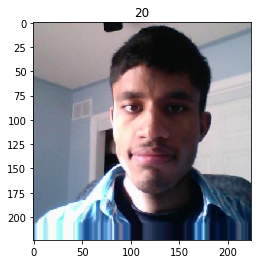

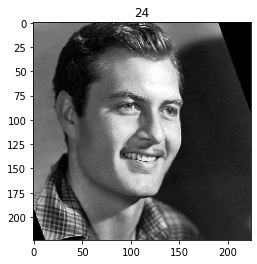

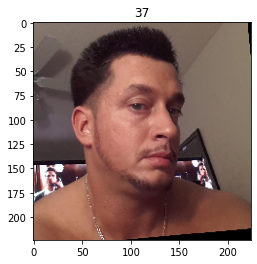

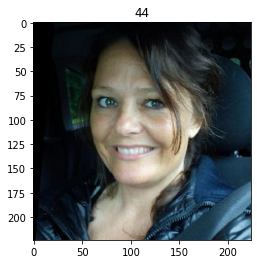

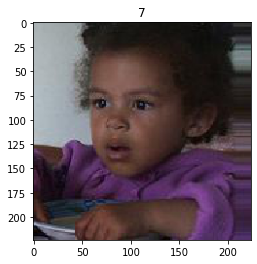

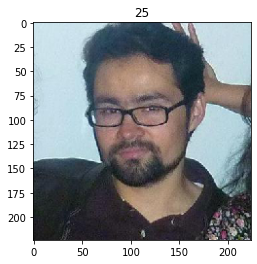

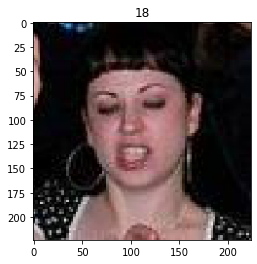

In [15]:
features, target = next(train_gen_flow)

for age, photo in zip(target[15:], features[15:]):
    plt.figure()
    plt.title(age)
    plt.imshow(photo)

Как видим из первых 15 кадров, некоторые фотографии черно-белые, есть уже повернутые изображения разных размеров (имею в виду размер на фоне черного фона), также есть искаженные картинки. Вероятно, подобные аугментации помогут в обучении модели.

Общая ориентация фотографий примерно одинакова - в некоторых фото их уже повернули за нас, чтобы выровнять положение лица, значит нам их не обязательно поворачивать, а начальный размер изображений отличается, в силу того, что визуально заметно различное качество фото, где-то есть черные рамки (они не несут полезной информации). В итоге, размер изображений мы приведем к единому перед обучением модели.


## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0

coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s

Using TensorFlow backend.

Found 5694 validated image filenames.

Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps

Epoch 1/10
356/356 - 55s - loss: 197.0781 - mae: 10.3214 - val_loss: 507.3323 - val_mae: 17.2615

Epoch 2/10
356/356 - 44s - loss: 80.7015 - mae: 6.8547 - val_loss: 137.4664 - val_mae: 8.8514

Epoch 3/10
356/356 - 46s - loss: 58.5999 - mae: 5.8251 - val_loss: 87.4240 - val_mae: 7.1893

Epoch 4/10
356/356 - 45s - loss: 42.8321 - mae: 4.9956 - val_loss: 80.3311 - val_mae: 6.6252

Epoch 5/10
356/356 - 45s - loss: 30.6580 - mae: 4.2324 - val_loss: 94.3200 - val_mae: 7.5617

Epoch 6/10
356/356 - 46s - loss: 24.9403 - mae: 3.8252 - val_loss: 83.1583 - val_mae: 7.0901

Epoch 7/10
356/356 - 45s - loss: 20.7970 - mae: 3.4571 - val_loss: 69.1944 - val_mae: 6.2403

Epoch 8/10
356/356 - 45s - loss: 17.4379 - mae: 3.1762 - val_loss: 82.1980 - val_mae: 6.7824

Epoch 9/10
356/356 - 46s - loss: 15.0475 - mae: 2.9887 - val_loss: 65.1606 - val_mae: 6.1380

Epoch 10/10
356/356 - 45s - loss: 12.7604 - mae: 2.7116 - val_loss: 65.8089 - val_mae: 5.9961


119/119 - 11s - loss: 65.8089 - mae: 5.9961
Test MAE: 5.9961

```

## Анализ обученной модели

Модель обучена на 10 эпохах. 7591 изображение поделено на батчи по 16 изображений, что дает обучение на 356 шагах и валидацию на 119 шагах.

Модель за 10 эпох не переобучается, значение Mean absolute error на валидационной выборке стабильно падает (с 17 до 5,9), а на тестовой выборке тоже не растёт. 

MAE на тестовой выборке составило 5,9961, что соответствует условиям от заказчика (MAE ниже 8), цель проекта достигнута.

Такое значение абсолютной средней ошибки говорит о том, что модель всё ещё может ошибаться в определении возраста человека на фотографии почти на 6 лет. Это позволяет в целом решать первую поставленную задачу заказчика (анализировать покупки и предлагать товары, которые могут заинтересовать покупателей той или иной возрастной группы), но требует доработки для решения задачи контроля добросовестность кассиров при продаже алкоголя, так как модель пока ещё может легко спутать 16-летнего с 22-летним. 
